In [1]:
import pandas as pd
from pprint import pprint
import stan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import nest_asyncio
nest_asyncio.apply()
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

In [2]:
neededData = pd.read_csv('./data/neededData.csv')
print(neededData.shape)
neededData.head()

(809660, 6)


,user_id,item_id,timestamp,correct,nb_hint,answers_using_hint
535958,72,563,1125395408,0,0,4
562642,247,563,1125395410,1,0,2
569598,249,563,1125395414,1,0,2
555691,212,563,1125395416,1,0,2
545705,154,563,1125395419,0,0,4


In [3]:
needed = neededData[["user_id","item_id","correct"]]
needed.head()

,user_id,item_id,correct
535958,72,563,0
562642,247,563,1
569598,249,563,1
555691,212,563,1
545705,154,563,0


# IRT Models

In [4]:
# From stan documentation
_1pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  real ability[S];             //  alpha: ability od student
  real difficulty[I];          //  beta: difficulty of question
  real delta;                   // man student ability
  
}
model {

  ability ~ std_normal();         
  difficulty ~ std_normal();   
  delta ~ normal(0.75,1);
  
  for(n in 1:N)
      grade[n] ~ bernoulli_logit(ability[subject[n]] - difficulty[item[n]] + delta);
  
}
"""
# 2pl
_2pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  vector[S] ability;             //  alpha ability od student
  vector[I] difficulty;          //  beta difficulty of question
  vector<lower=0>[I] discrimination;      // discrimination of question
  real mu_difficulty;
}
model {
  ability ~ std_normal();         
  difficulty ~ std_normal();   
  discrimination ~ lognormal(0,1);
  mu_difficulty ~ cauchy(0,5);
  
  grade ~ bernoulli_logit(discrimination[item] .* (ability[subject] - (difficulty[item] + mu_difficulty)));
  
}
"""
# Model from Stan documantation
multilevel_2pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  vector[S] ability;             //  alpha ability od student
  vector[I] difficulty;          //  beta difficulty of question
  vector<lower=0>[I] discrimination;      // discrimination of question
  
  // hyperparameters
  
  real mu_difficulty;                       // mean question difficulty
  real<lower=0> sigma_difficulty;           // scale of difficulty
  real<lower=0> sigma_discrimination;                // scale of log discrimination
}
model {
  ability ~ std_normal();         
  difficulty ~ normal(0,sigma_difficulty);   
  discrimination ~ lognormal(0,sigma_discrimination);
  
  mu_difficulty ~ cauchy(0,5);
  sigma_difficulty ~ cauchy(0,5);
  sigma_discrimination ~ cauchy(0,5);
  
  grade ~ bernoulli_logit(discrimination[item] .* (ability[subject] - (difficulty[item] + mu_difficulty)));
  
}

generated quantities {
  int<lower=0,upper=1> y_pred[N];
  for(n in 1:N)
      y_pred[n] = bernoulli_logit_rgn(discrimination[item[n]] * (ability[subject[n]] - (difficulty[item[n]] + mu_difficulty)));
}

"""

In [5]:
train_data = {'I': len(needed['item_id'].unique()),
              'S': len(needed['user_id'].unique()),
              'N': len(needed),
              'item': needed['item_id'].to_numpy(),
              'subject': needed['user_id'].to_numpy(),
              'grade': needed['correct'].to_numpy(),}
pprint(train_data)

{'I': 1084,
 'N': 809660,
 'S': 569,
 'grade': array([0, 1, 1, ..., 1, 1, 1]),
 'item': array([563, 563, 563, ..., 482, 482, 482]),
 'subject': array([ 72, 247, 249, ..., 392, 392, 392])}


In [6]:
posteriori = stan.build(_1pl_model,data=train_data,random_seed=2021)

Building...



Building: found in cache, done.

In [ ]:
# fit model
binary_fit = posteriori.sample(num_chains=2, num_samples=50000,num_warmup=1000,num_thin=1)

Sampling:   0%
Sampling:   0% (1/102000)
Sampling:   0% (2/102000)
Sampling:   0% (101/102000)
Sampling:   0% (200/102000)
Sampling:   0% (300/102000)
Sampling:   0% (400/102000)

In [10]:
# print fit summary
print(binary_fit)

<stan.Fit>
Parameters:
    ability: (569,)
    difficulty: (1084,)
    discrimination: (1084,)
    mu_difficulty: ()
Draws: 8000


In [10]:
# draw summary plot
f = binary_fit.plot()
f.set_size_inches(18, 10)
plt.tight_layout()
# On obtient donc "Item Information Functions"

AttributeError: 'Fit' object has no attribute 'plot'

# Export IRT Model

In [14]:
with open("./data/_1pl_model_chains-2_numsamples-10000_numwarmup-1000_num_thin-1.pkl", "wb") as f:
    pickle.dump({'model' : posteriori, 'fit' : binary_fit}, f, protocol=-1)

# import IRT Model

In [7]:
with open("./data/_1pl_model_chains-2_numsamples-10000_numwarmup-1000_num_thin-1.pkl", "rb") as f:
    data_dict = pickle.load(f)
fit = data_dict['fit']
fit

<stan.Fit>
Parameters:
    ability: (569,)
    difficulty: (1084,)
    delta: ()
Draws: 20000

In [8]:
ability = np.mean(fit['ability'],axis=1)
difficulty = np.mean(fit['difficulty'],axis=1)
#discrimination = np.mean(binary_fit['discrimination'],axis=1)

In [10]:
y_pred = []
for i in range(0,809660):
    diff = train_data['item'][i]
    abilt = train_data['subject'][i]
    p = np.exp(ability[abilt - 1 ] - difficulty[diff - 1])/(1+np.exp(ability[abilt - 1] - difficulty[diff - 1]))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [11]:
np.unique(y_pred)

array([0, 1])

In [12]:
mse = mean_squared_error(train_data['grade'],y_pred)
mse

0.42118914112096434

In [13]:
x = cohen_kappa_score(train_data['grade'],y_pred)
x

0.15877255234989252

<AxesSubplot:>

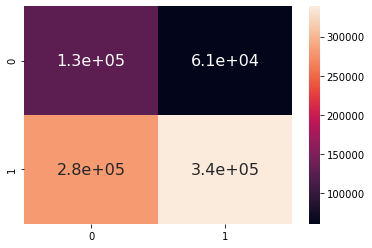

In [23]:
from sklearn.metrics import confusion_matrix
fm = confusion_matrix(train_data['grade'],y_pred)
sns.heatmap(fm, annot=True, annot_kws={"size": 16}) # font size

In [15]:
roc_auc_score(train_data['grade'],y_pred)

0.6110461386380821

In [16]:
accuracy_score(train_data['grade'],y_pred)

0.5788108588790356

In [1]:
# Model selection

In [ ]:
import arviz as az

In [ ]:
idata = az.from_pystan(binary_fit, log_likelihood="log_lik")
waic = az.waic(idata)
loo = az.loo(idata)

In [ ]:
idata = az.from_pystan(binary_fit2, log_likelihood="log_lik")
waic = az.waic(idata)
loo = az.loo(idata)

# 2PL model

In [47]:
fit['ability'].shape

(569, 20)

In [42]:
ability = np.mean(fit['ability'],axis=1)
difficulty = np.mean(fit['difficulty'],axis=1)
discrimination = np.mean(fit['gamma'],axis=1)

In [53]:
discrimination[1084]

IndexError: index 1084 is out of bounds for axis 0 with size 1084

In [54]:
y_pred = []
for i in range(0,809660):
    diff = train_data['item'][i]
    abilt = train_data['subject'][i]
    p = np.exp(discrimination[diff-1]*(ability[abilt - 1 ] - difficulty[diff - 1]))/(1+np.exp(discrimination[diff-1]*(ability[abilt - 1] - difficulty[diff - 1])))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int)
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [57]:
x = cohen_kappa_score(train_data['grade'],y_pred)
x

-0.10718992370530889

In [56]:
mse = mean_squared_error(train_data['grade'],y_pred)
mse

0.5572067287503396